In [1]:
%env MUJOCO_GL=egl
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.5

from typing import Any, Dict, Optional, Union

import numpy as np
import torch
import jax
import jax.numpy as jp
from etils import epath
import mujoco
import mediapy

from mujoco_playground import wrapper
from mujoco_playground._src.manipulation.airbot_play.pick import AirbotPlayPickCube, default_config

env = AirbotPlayPickCube(
    config=default_config()
)

num_envs = 64
episode_length = int(4 / env._config.ctrl_dt)
rng = jax.random.PRNGKey(0)
env_wrap = wrapper.wrap_for_brax_training(
    env,
    vision=False, 
    num_vision_envs=num_envs,
    episode_length=episode_length,
    action_repeat=1
)
state = env_wrap.reset(jax.random.split(rng, num_envs))
state = env_wrap.step(state, jp.zeros((num_envs, env.mj_model.nu)))

print(f"=== geom num === {env.mj_model.ngeom}")
print(state.data.geom_xpos.shape, state.data.geom_xmat.shape)
# (4, 30, 3) (4, 30, 3, 3)
print(f"=== cam num === {env.mj_model.ncam}")
print(state.data.cam_xpos.shape, state.data.cam_xmat.shape)
# (4, 1, 3) (4, 1, 3, 3)
print(f"=== body num === {env.mj_model.nbody}")
print(state.data.xpos.shape, state.data.xmat.shape)
# (4, 13, 3) (4, 13, 3, 3)

env: MUJOCO_GL=egl
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.5


/root/miniconda3/lib/python3.10/site-packages/jax/_src/interpreters/xla.py:119: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


=== geom num === 25
(64, 25, 3) (64, 25, 3, 3)
=== cam num === 1
(64, 1, 3) (64, 1, 3, 3)
=== body num === 13
(64, 13, 3) (64, 13, 3, 3)


In [8]:
from discoverse.robots_env.airbot_play_base import AirbotPlayBase, AirbotPlayCfg

cfg = AirbotPlayCfg()
cfg.gs_model_dict["background"] = "scene/lab3/point_cloud.ply"
cfg.init_qpos[:] = [-0.055, -0.547, 0.905, 1.599, -1.398, -1.599,  0.0]

robot_name = "airbot_play"
cfg.mjcf_file_path = f"mjcf/manipulator/robot_airbot_play.xml"

cfg.timestep     = 1/240
cfg.decimation   = 4
cfg.sync         = True
cfg.headless     = True
cfg.render_set   = {
    "fps"    : 20,
    "width"  : 640, #80, # 192, # 128, # 640, #1920
    "height" : 480, #80, # 108, # 128, # 480, #1080
}
cfg.obs_rgb_cam_id = [0]
# cfg.obs_depth_cam_id = [0, 1]
cfg.use_gaussian_renderer = True
sim_node = AirbotPlayBase(cfg)
# obs = sim_node.reset()
# mediapy.show_image(obs['img'][0])

mjcf found: /root/code/DISCOVERSE/models/mjcf/manipulator/robot_airbot_play.xml
screeninfo error: No enumerators available, using default screen size: 1920x1080


""

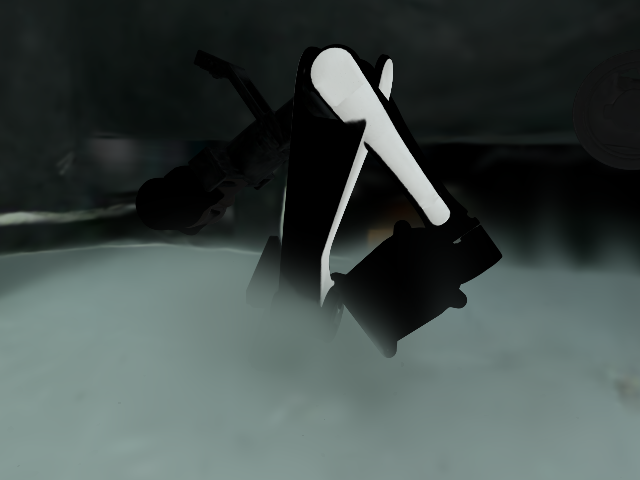

In [9]:
from discoverse.gaussian_renderer import batch_render, batch_env_render, batch_update_gaussians
import torch.utils.dlpack as tpack

gsb = batch_update_gaussians(
    sim_node.gs_renderer.renderer.gaussians,
    tpack.from_dlpack(state.data.xpos),
    tpack.from_dlpack(state.data.xquat),
    sim_node.gs_idx_start,
    sim_node.gs_idx_end,
    sim_node.gs_body_ids
)

rgb_imgs, depth_imgs = batch_env_render(
    gsb,
    tpack.from_dlpack(state.data.cam_xpos),
    tpack.from_dlpack(state.data.cam_xmat),
    cfg.render_set["height"],
    cfg.render_set["width"],
    env.mj_model.cam_fovy
)

mediapy.show_image(rgb_imgs[0,0].cpu().numpy())

In [16]:
print(sim_node.gs_renderer.renderer.gaussians.sh.shape)
print(gsb.sh.shape)

torch.Size([722999, 1, 3])
torch.Size([64, 722999, 1, 3])


CUDA Event计时: 41.09 ms
平均每秒渲染图像：1557.73
torch.Size([64, 1, 128, 128, 3]) torch.Size([64, 1, 128, 128, 1])


""

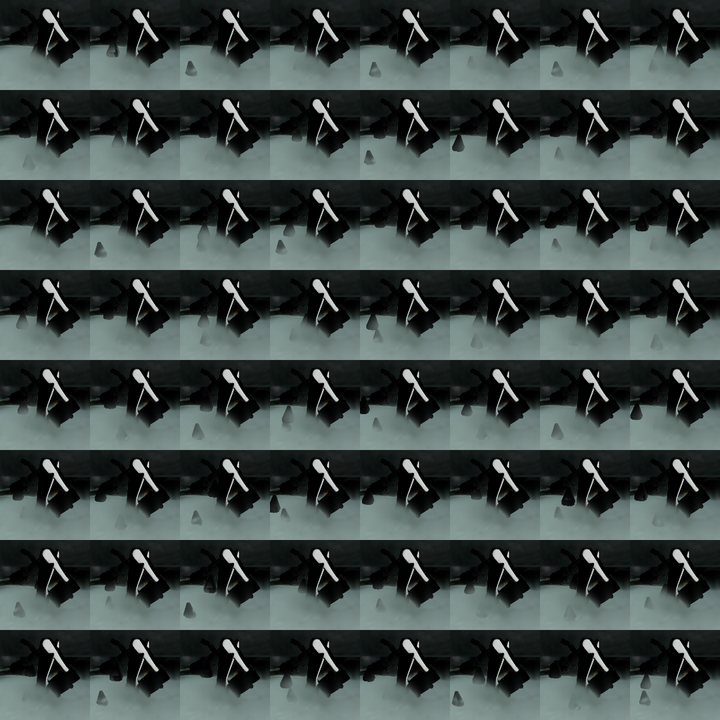

In [17]:
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

num_run = 100

torch.cuda.synchronize()
start_event.record()

for _ in range(num_run):
    gsb = batch_update_gaussians(
        sim_node.gs_renderer.renderer.gaussians,
        # tpack.from_dlpack(state.data.xpos) + (torch.rand_like(tpack.from_dlpack(state.data.xpos)) - 0.5) * 0.05,
        tpack.from_dlpack(state.data.xpos),
        tpack.from_dlpack(state.data.xquat),
        sim_node.gs_idx_start,
        sim_node.gs_idx_end,
        sim_node.gs_body_ids
    )

    rgb_imgs, depth_imgs = batch_env_render(
        gsb,
        tpack.from_dlpack(state.data.cam_xpos),
        tpack.from_dlpack(state.data.cam_xmat),
        128, #cfg.render_set["height"],
        128, #cfg.render_set["width"],
        env.mj_model.cam_fovy
    )

end_event.record()
torch.cuda.synchronize()
elapsed_time = start_event.elapsed_time(end_event)
print(f"CUDA Event计时: {elapsed_time / num_run:.2f} ms")
print(f"平均每秒渲染图像：{num_envs * env.mj_model.ncam * 1e3 / (elapsed_time / num_run):.2f}")

print(rgb_imgs.shape, depth_imgs.shape)

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)

mediapy.show_image(tile(rgb_imgs.detach().cpu().numpy()[:,0,...], 8), width=720)
# mediapy.show_image(np.hstack([tile(rgb_imgs.detach().cpu().numpy()[:,0,...], 8), tile(rgb_imgs.detach().cpu().numpy()[:,1,...], 8)]), width=720*2)

In [18]:
import torch
torch.cuda.empty_cache()